In [6]:
# if (!requireNamespace("remotes", quietly = TRUE)) {
#   install.packages("remotes")
# }
# remotes::install_github("mojaveazure/seurat-disk", 
#                         upgrade = FALSE)

In [61]:
library(nichenetr)
library(Seurat) # please update to Seurat V4
# library(SeuratObject)
library(tidyverse)
library(anndata)

In [62]:
utils::packageVersion('Seurat')

[1] ‘4.1.1’

In [63]:
# seuratObj = readRDS('data/seuratObj.rds')
adata = read_h5ad('data/GSE120575_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [29]:
# seuratObj = readRDS('data/seuratObj.rds')
adata = read_h5ad('data/GSE120575_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
head(adata$X, 3)

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,⋯,RP11-126K1.9,RP4-671G15.2,OR6R2P,RP11-225H22.7,RP11-731C17.2,RP4-621B10.8,RP11-114I8.4,RP11-180C16.1,AP000230.1,RP11-80H18.4
A10_P3_M11,0,0,0.00,0,0,0,0,0,0.00,0,⋯,0,0,0,0,8.1,0,0,0,0,0
A11_P1_M11,0,0,9.24,0,0,0,0,0,1.01,0,⋯,0,0,0,0,0.0,0,0,0,0,0
A11_P3_M11,0,0,0.00,0,0,0,0,0,0.00,0,⋯,0,0,0,0,0.0,0,0,0,0,0


In [31]:
head(adata$obs, 3)

,Sample name,source name,organism,sample_id,response,therapy,patient_id,time_point,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
A10_P3_M11,Sample 1,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,2050,2050,14624.81,171.21,1.170682,Dendritic cells
A11_P1_M11,Sample 2,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,1573,1573,11933.60,160.35,1.343685,B cells
A11_P3_M11,Sample 3,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,1591,1590,11877.65,176.23,1.483711,Memory T cells


In [64]:
seuratObj = Seurat::CreateSeuratObject(t(adata$X), 
                               project = "GSE120575_annotated", 
                               assay = "RNA",
                               min.cells = 0, 
                               min.features = 0, 
                               names.field = 1,
                               names.delim = "_", 
                               meta.data = adata$obs)
seuratObj

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Sample.namesource.nameorganismsample_idresponsetherapypatient_idtime_pointn_genesn_genes_by_countstotal_countstotal_counts_mtpct_counts_mtcell_type; see ?make.names for more details on syntax validity”


An object of class Seurat 
45884 features across 16215 samples within 1 assay 
Active assay: RNA (45884 features, 0 variable features)

In [35]:
# Check what caused the warning messages
# These genes are not protein-encoding (for ligands or receptors)
rownames(adata$var)[grepl('_', rownames(adata$var))]

[1] "RP11-544L8__B.4"  "RP1-232L22__B.1"  "Y_RNA"            "5S_rRNA"         
 [5] "RP11-453F18__B.1" "RP11-135M8__A.1"  "RP11-59D5__B.3"   "RP11-323I14__A.1"
 [9] "RP4-633O19__A.1"  "XXyac-YX65C7_A.4" "RP11-210H10__A.1" "XXyac-YX65C7_A.2"
[13] "RP11-445L13__B.3" "RP1-232L22__A.1"  "RP11-442N24__B.1" "RP11-293G6__A.3" 
[17] "RP11-632C17__A.1" "RP11-293G6__B.4"  "XXyac-YX65C7_A.3" "CTA-280A3__B.2"  
[21] "RP11-293G6__B.2"  "RP4-754E20__A.5"  "RP11-59D5__B.2"   "RP3-336K20__B.2" 
[25] "RP11-4K3__A.5"    "RP11-293G6__A.2"  "RP11-4K3__A.3"    "RP11-99J16__A.2" 
[29] "snoZ13_snr52"     "Metazoa_SRP"      "XX-DJ76P10__A.2"  "RP11-524D16__A.3"
[33] "RP11-1157N2__B.2" "RP11-293G6__B.8"

In [12]:
head(seuratObj@meta.data, 3)

,orig.ident,nCount_RNA,nFeature_RNA,Sample.name,source.name,organism,sample_id,response,therapy,patient_id,time_point,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
A10_P3_M11,P3,14624.81,2050,Sample 1,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,2050,2050,14624.81,171.21,1.1706818,Dendritic cells
A11_P1_M11,P1,11933.60,1573,Sample 2,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,1573,1573,11933.60,160.35,1.3436852,B cells
A11_P3_M11,P3,11877.65,1590,Sample 3,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,1591,1590,11877.65,176.23,1.4837110,Memory T cells
A11_P4_M11,P4,19693.54,2909,Sample 4,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,2909,2909,19693.54,146.83,0.7455744,Regulatory T cells
A12_P3_M11,P3,9182.32,1210,Sample 5,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,1211,1210,9182.32,196.08,2.1354077,others
A12_P6_M11,P6,18240.40,2715,Sample 6,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre,2715,2715,18240.40,140.46,0.7700490,CD8+ T cells


In [65]:
Idents(seuratObj) = 'cell_type'
head(Idents(seuratObj))

A10_P3_M11         A11_P1_M11         A11_P3_M11         A11_P4_M11 
   Dendritic cells            B cells     Memory T cells Regulatory T cells 
        A12_P3_M11         A12_P6_M11 
            others       CD8+ T cells 
9 Levels: B cells CD4+ T cells CD8+ T cells ... others

In [19]:
ligand_target_matrix = readRDS('data/ligand_target_matrix.rds')
ligand_target_matrix[1:5,1:5]

,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


In [20]:
lr_network = readRDS('data/lr_network.rds')
head(lr_network, 3)

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg
CXCL3,CXCR2,kegg_cytokines,kegg
CXCL5,CXCR2,kegg_cytokines,kegg
PPBP,CXCR2,kegg_cytokines,kegg
CXCL6,CXCR2,kegg_cytokines,kegg


In [21]:
weighted_networks = readRDS('data/weighted_networks.rds')
weighted_networks_lr = weighted_networks$lr_sig %>% 
    inner_join(lr_network %>% 
               distinct(from,to), 
               by = c("from","to"))
head(weighted_networks$lr_sig, 3)

from,to,weight
<chr>,<chr>,<dbl>
A1BG,ABCC6,0.42164389
A1BG,ACE2,0.10074109
A1BG,ADAM10,0.09698978
A1BG,AGO1,0.05245879
A1BG,AKT1,0.08553468
A1BG,ANXA7,0.45659947


## Define the sender and receiver niches

In [67]:
## receiver
receiver = "CD8+ T cells"
# receiver = "CD8 T"
expressed_genes_receiver = get_expressed_genes(receiver, seuratObj, pct = 0.10)

background_expressed_genes = expressed_genes_receiver %>% 
    .[. %in% rownames(ligand_target_matrix)]

In [98]:
## sender
# sender_celltypes = c(
#      "CD4+ T cells",
#      "Dendritic cells", 
#      "Regulatory T cells", 
#      "B cells", 
#      "Macrophages"
# )

sender_celltypes = "Dendritic cells"

list_expressed_genes_sender = sender_celltypes %>% 
    unique() %>% 
# lapply to get the expressed genes of every sender cell type separately here
    lapply(get_expressed_genes, seuratObj, 0.10) 
expressed_genes_sender = list_expressed_genes_sender %>% 
    unlist() %>% 
    unique()

## Define a gene set of interest

In [68]:
seuratObj@meta.data$response %>% table()

.
Non-responder     Responder 
        10655          5560 

In [86]:
seurat_obj_receiver = subset(seuratObj, 
                             idents = receiver)
# head(seurat_obj_receiver)
seurat_obj_receiver = SetIdent(seurat_obj_receiver, 
                               value = seurat_obj_receiver[["response"]])

# condition_oi = "Responder"
# condition_reference = "Non-responder" 

condition_oi = "Non-responder"
condition_reference = "Responder"
  
DE_table_receiver = FindMarkers(
    object = seurat_obj_receiver, 
    ident.1 = condition_oi, 
    ident.2 = condition_reference, 
    min.pct = 0.10
) %>% 
    rownames_to_column("gene")

geneset_oi = DE_table_receiver %>% 
    filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25) %>% 
    pull(gene)
geneset_oi = geneset_oi %>% 
    .[. %in% rownames(ligand_target_matrix)]

In [126]:
DE_table_receiver[DE_table_receiver$gene == "PDCD1",]

,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
86,PDCD1,1.415157e-38,0.4088876,0.521,0.327,6.493308e-34


In [127]:
DE_table_receiver[DE_table_receiver$gene == "CTLA4",]

,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
318,CTLA4,3.072223e-20,-0.2827518,0.436,0.297,1.409659e-15


## Define a set of potential ligands

In [87]:
ligands = lr_network %>% 
    pull(from) %>% 
    unique()
receptors = lr_network %>% 
    pull(to) %>% 
    unique()

expressed_ligands = intersect(ligands, 
                              expressed_genes_sender)
expressed_receptors = intersect(receptors, 
                                expressed_genes_receiver)

potential_ligands = lr_network %>% 
    filter(
        from %in% expressed_ligands & to %in% expressed_receptors
    ) %>% 
    pull(from) %>% 
    unique()

## Perform the analysis of the ligand activity

In [88]:
ligand_activities = predict_ligand_activities(
    geneset = geneset_oi, 
    background_expressed_genes = background_expressed_genes, 
    ligand_target_matrix = ligand_target_matrix, 
    potential_ligands = potential_ligands
)

ligand_activities = ligand_activities %>% 
    arrange(-pearson) %>% 
    mutate(rank = rank(desc(pearson)))

In [89]:
head(ligand_activities, 20)

test_ligand,auroc,aupr,aupr_corrected,pearson,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFNG,0.5669449,0.2037218,0.05938494,0.12007800,1
HMGB2,0.5502063,0.1939701,0.04963317,0.11863102,2
TGFB1,0.5416029,0.1813198,0.03698293,0.08064184,3
APOE,0.5430092,0.1760072,0.03167031,0.07873057,4
IL15,0.5444833,0.1790856,0.03474872,0.07666539,5
TNF,0.5492518,0.1819413,0.03760442,0.07510518,6
CCL2,0.5524644,0.1783273,0.03399039,0.07484357,7
ADAM17,0.5499046,0.1785477,0.03421081,0.07482277,8
TNFSF13B,0.5530143,0.1787144,0.03437746,0.07375104,9


In [90]:
n_best = 19
best_upstream_ligands = ligand_activities %>% 
    top_n(n_best, pearson) %>% 
    arrange(-pearson) %>% 
    pull(test_ligand) %>% 
    unique()

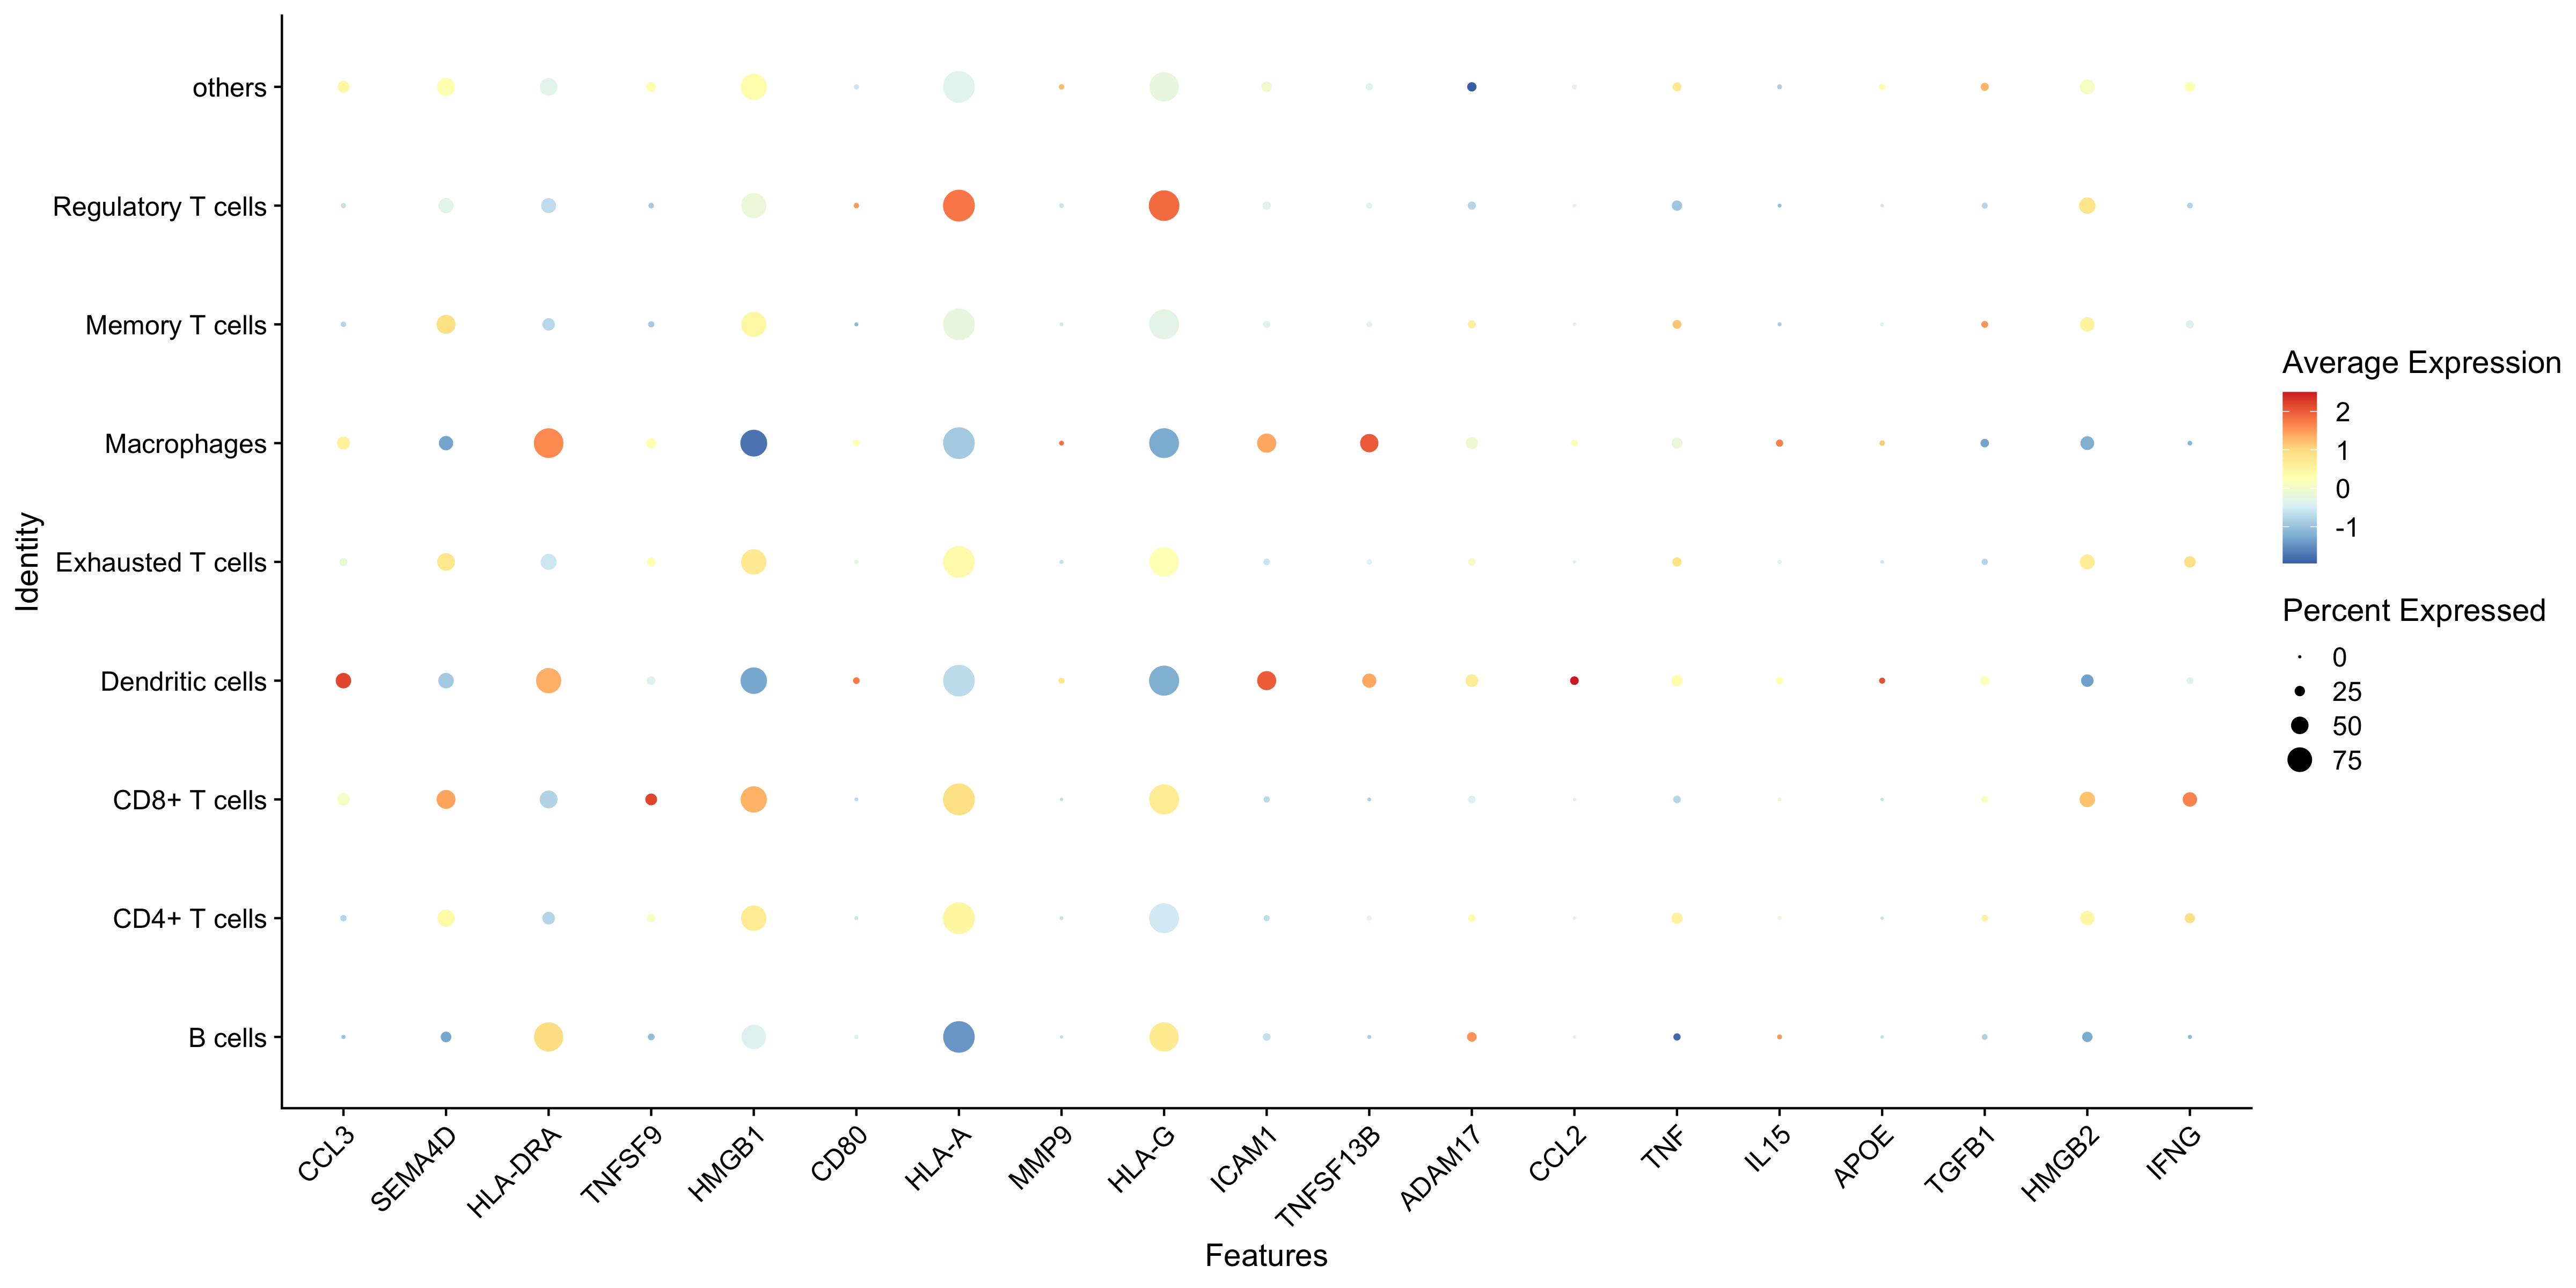

In [97]:
options(repr.plot.width=16, 
        repr.plot.height=8, 
        repr.plot.res=300)
# DotPlot is a function in the library Seurat
DotPlot(seuratObj, 
        features = best_upstream_ligands %>% 
            rev(), cols = "RdYlBu"
       ) + 
    RotatedAxis()

## Infer receptors

In [75]:
# active_ligand_target_links_df = best_upstream_ligands %>% 
#     lapply(get_weighted_ligand_target_links,
#            geneset = geneset_oi, 
#            ligand_target_matrix = ligand_target_matrix, 
#            n = 200) %>% 
#     bind_rows() %>% 
#     drop_na()

# active_ligand_target_links = prepare_ligand_target_visualization(
#     ligand_target_df = active_ligand_target_links_df, 
#     ligand_target_matrix = ligand_target_matrix, 
#     cutoff = 0.33
# )

# order_ligands = intersect(
#     best_upstream_ligands, 
#     colnames(active_ligand_target_links)) %>% 
#     rev() %>% 
#     make.names()
# order_targets = active_ligand_target_links_df$target %>% 
#     unique() %>% 
#     intersect(rownames(active_ligand_target_links)) %>% 
#     make.names()
# rownames(active_ligand_target_links) = rownames(active_ligand_target_links) %>% 
#     make.names() # make.names() for heatmap visualization of genes like H2-T23
# colnames(active_ligand_target_links) = colnames(active_ligand_target_links) %>% 
#     make.names() # make.names() for heatmap visualization of genes like H2-T23

# vis_ligand_target = active_ligand_target_links[order_targets,order_ligands] %>% 
#     t()

In [80]:
# p_ligand_target_network = vis_ligand_target %>% 
#     make_heatmap_ggplot("Prioritized ligands",
#                         "Predicted target genes", 
#                         color = "purple",
#                         legend_position = "top", 
#                         x_axis_position = "top",
#                         legend_title = "Regulatory potential")  + 
#     theme(axis.text.x = element_text(face = "italic")) + 
#     scale_fill_gradient2(low = "whitesmoke",  
#                          high = "purple", 
#                          breaks = c(0, 0.0045, 0.0090))
# p_ligand_target_network

In [91]:
lr_network_top = lr_network %>% 
    filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% 
    distinct(from,to)
best_upstream_receptors = lr_network_top %>% 
    pull(to) %>% 
    unique()

lr_network_top_df_large = weighted_networks_lr %>% 
    filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors)

lr_network_top_df = lr_network_top_df_large %>% 
    spread("from","weight",fill = 0)
lr_network_top_matrix = lr_network_top_df %>% 
    select(-to) %>% 
    as.matrix() %>% 
    magrittr::set_rownames(lr_network_top_df$to)

dist_receptors = dist(lr_network_top_matrix, method = "binary")
hclust_receptors = hclust(dist_receptors, method = "ward.D2")
order_receptors = hclust_receptors$labels[hclust_receptors$order]
    
dist_ligands = dist(lr_network_top_matrix %>% t(), 
                    method = "binary")
hclust_ligands = hclust(dist_ligands, 
                        method = "ward.D2")
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order]

order_receptors = order_receptors %>% 
    intersect(rownames(lr_network_top_matrix))
order_ligands_receptor = order_ligands_receptor %>% 
    intersect(colnames(lr_network_top_matrix))

vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, 
                                                    order_ligands_receptor]
rownames(vis_ligand_receptor_network) = order_receptors %>% 
    make.names()
colnames(vis_ligand_receptor_network) = order_ligands_receptor %>% 
    make.names()

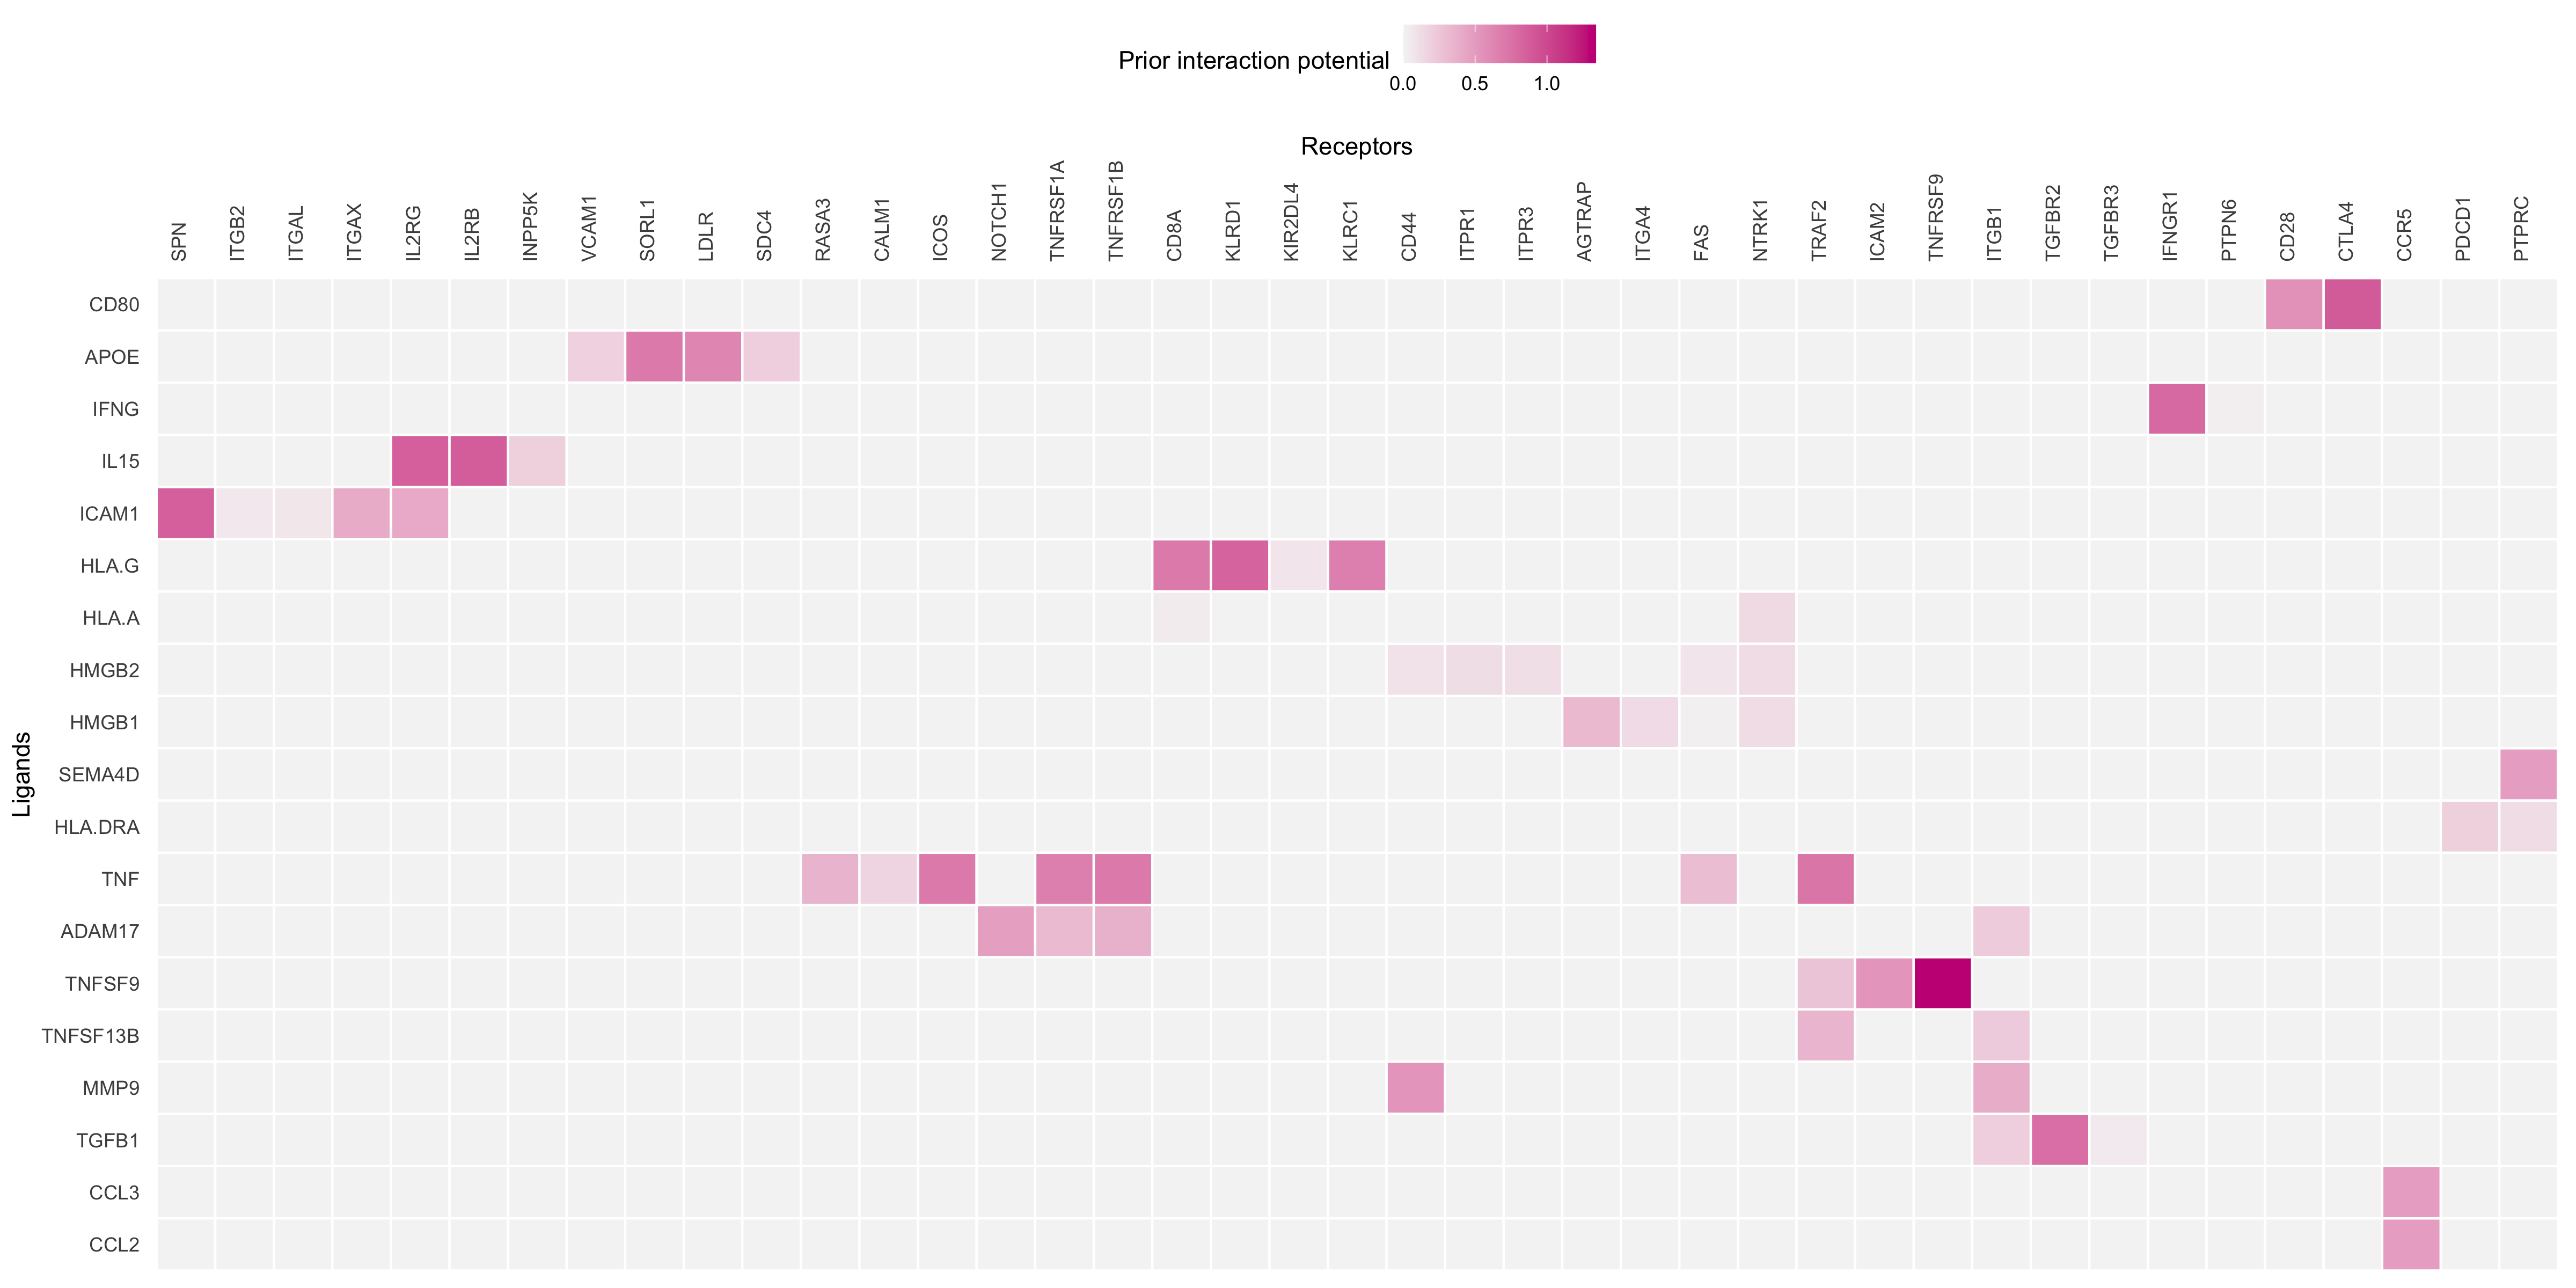

In [92]:
options(repr.plot.width=16, 
        repr.plot.height=8, 
        repr.plot.res=300)
p_ligand_receptor_network = vis_ligand_receptor_network %>% 
    t() %>% 
    make_heatmap_ggplot("Ligands",
                        "Receptors", 
                        color = "mediumvioletred", 
                        x_axis_position = "top",
                        legend_title = "Prior interaction potential")
p_ligand_receptor_network

In [117]:
# DE analysis for each sender cell type
# this uses a new function - 
# reinstall nichenetr if necessary
DE_table_all = Idents(seuratObj) %>% 
    levels() %>% 
    intersect(sender_celltypes) %>% 
    lapply(
       get_lfc_celltype, 
       seurat_obj = seuratObj, 
       condition_colname = "response", 
       condition_oi = condition_oi, 
       condition_reference = condition_reference, 
       expression_pct = 0.10, 
#        celltype_col = NULL
       celltype_col = "cell_type"
    ) %>% 
# use this if cell type labels are 
# the identities of the Seurat object -- 
# if not: indicate the celltype_col properly
    reduce(full_join) 
DE_table_all[is.na(DE_table_all)] = 0

# Combine ligand activities with DE information
ligand_activities_de = ligand_activities %>% 
    select(test_ligand, pearson) %>% 
    rename(ligand = test_ligand) %>% 
    left_join(DE_table_all %>% rename(ligand = gene))
ligand_activities_de[is.na(ligand_activities_de)] = 0

# make LFC heatmap
lfc_matrix = ligand_activities_de  %>% 
    select(-ligand, -pearson) %>% 
    as.matrix() %>% 
    magrittr::set_rownames(ligand_activities_de$ligand)
rownames(lfc_matrix) = rownames(lfc_matrix) %>% 
    make.names()

order_ligands = order_ligands[
    order_ligands %in% rownames(lfc_matrix)
]
# vis_ligand_lfc = lfc_matrix[order_ligands,]
# vis_ligand_lfc = data.frame(lfc_matrix[order_ligands,])
vis_ligand_lfc = data.matrix(lfc_matrix[order_ligands,])

colnames(vis_ligand_lfc) = vis_ligand_lfc %>% 
    colnames() %>% make.names()
vis_ligand_lfc

Joining, by = "ligand"


CCL3,1.65138264
SEMA4D,-0.27351524
HLA.DRA,0.80135898
TNFSF9,-0.33751385
HMGB1,0.18171887
CD80,0.00000000
HLA.A,0.17645480
MMP9,0.00000000
HLA.G,0.00000000
ICAM1,0.07186701
TNFSF13B,0.00000000


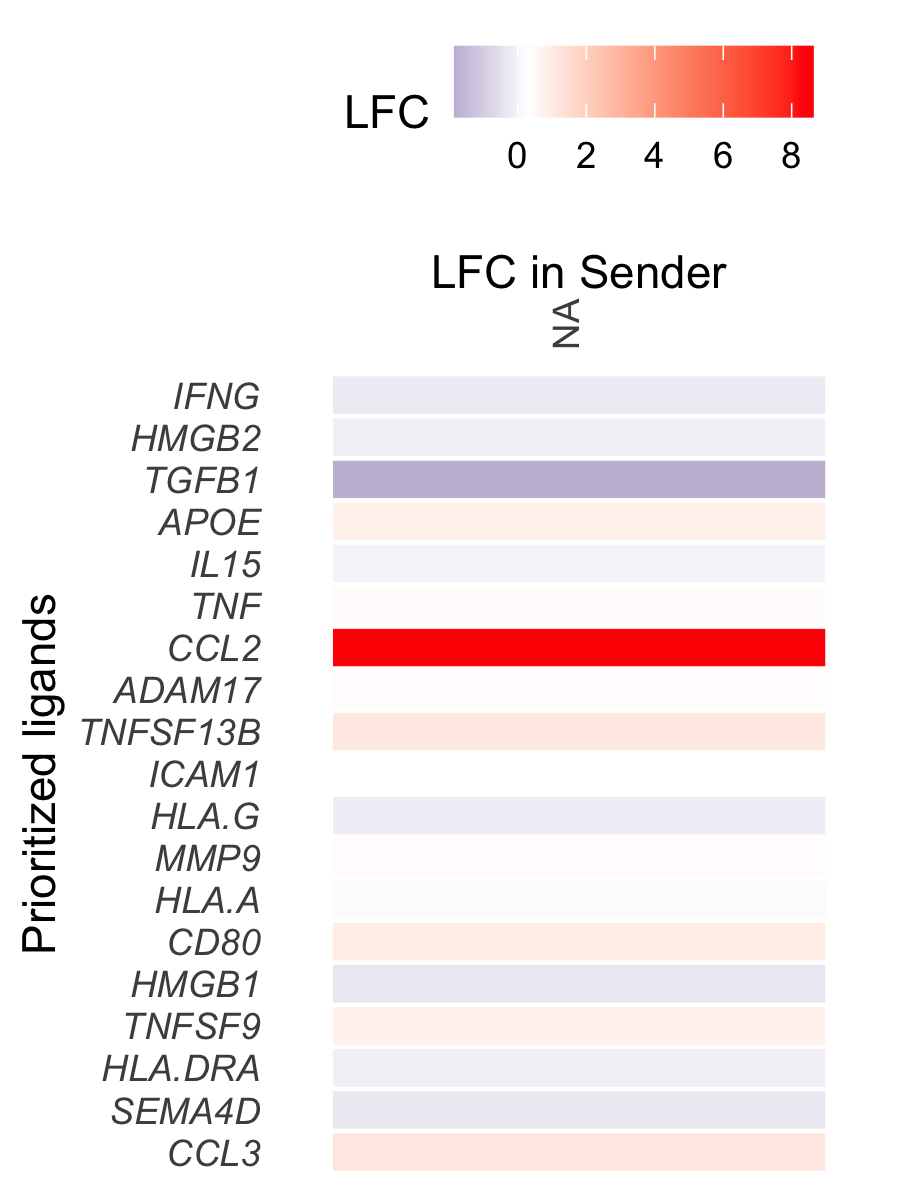

In [116]:
options(repr.plot.width=3, 
        repr.plot.height=4, 
        repr.plot.res=300)
p_ligand_lfc = vis_ligand_lfc %>% 
    make_threecolor_heatmap_ggplot("Prioritized ligands",
                                   "LFC in Sender", 
                                   low_color = "midnightblue",
                                   mid_color = "white", 
                                   mid = median(as.numeric(as.vector(vis_ligand_lfc))), 
                                   high_color = "red",
                                   legend_position = "top", 
                                   x_axis_position = "top", 
                                   legend_title = "LFC") + 
        theme(axis.text.y = element_text(face = "italic"))
p_ligand_lfc

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



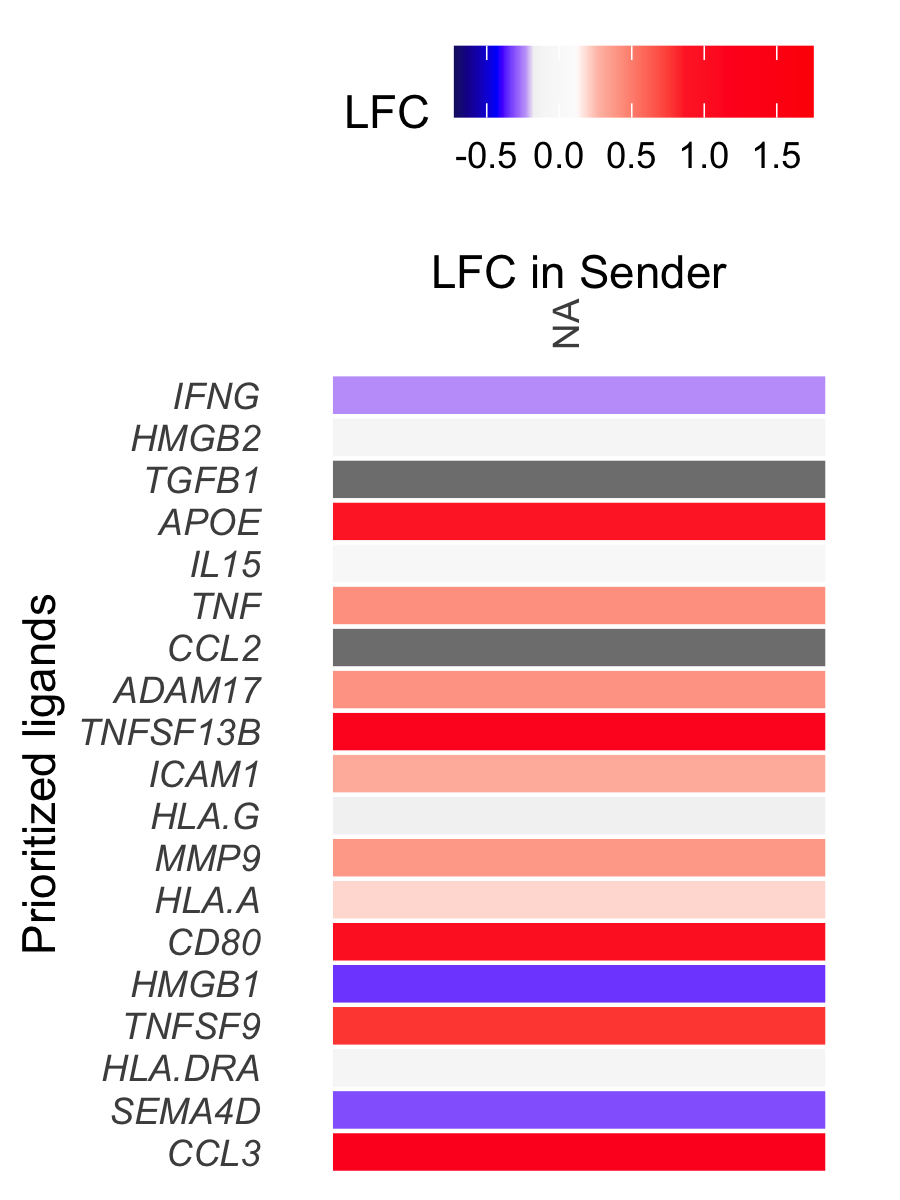

In [118]:
# change colors a bit to make them more stand out
p_ligand_lfc = p_ligand_lfc + 
    scale_fill_gradientn(
        colors = c("midnightblue",
                   "blue", 
                   "grey95", 
                   "grey99",
                   "firebrick1",
                   "red"),
        values = c(0,0.1,0.2,0.25,0.40,0.7,1), 
        limits = c(vis_ligand_lfc %>% min() - 0.1, 
                   vis_ligand_lfc %>% max() + 0.1)
    )
p_ligand_lfc

In [129]:
# indicated cell types should be cell class identities
# check via: 
# seuratObj %>% Idents() %>% table()
nichenet_output = nichenet_seuratobj_aggregate(
    seurat_obj = seuratObj, 
    receiver = "CD8+ T cells", 
    condition_colname = "response", 
    condition_oi = "Responder", 
    condition_reference = "Non-responder", 
    sender = "Dendritic cells", 
    ligand_target_matrix = ligand_target_matrix, 
    lr_network = lr_network, 
    weighted_networks = weighted_networks, 
    organism = "human")

[1] "Read in and process NicheNet's networks"
[1] "Define expressed ligands and receptors in receiver and sender cells"
[1] "Perform DE analysis in receiver cell"
[1] "Perform NicheNet ligand activity analysis"
[1] "Infer active target genes of the prioritized ligands"
[1] "Infer receptors of the prioritized ligands"
[1] "Perform DE analysis in sender cells"


In [130]:
nichenet_output$top_receptors

[1] "ITGB1"    "NOTCH1"   "TNFRSF1A" "TNFRSF1B" "LDLR"     "SDC4"    
 [7] "SORL1"    "VCAM1"    "CCR5"     "CD28"     "CTLA4"    "CD8A"    
[13] "NTRK1"    "PDCD1"    "PTPRC"    "KIR2DL4"  "KLRC1"    "KLRD1"   
[19] "AGTRAP"   "FAS"      "ITGA4"    "CD44"     "ITPR1"    "ITPR3"   
[25] "IL2RG"    "ITGAL"    "ITGAX"    "ITGB2"    "SPN"      "IFNGR1"  
[31] "PTPN6"    "IL2RB"    "INPP5K"   "ADRB2"    "TGFBR2"   "TGFBR3"  
[37] "CALM1"    "ICOS"     "RASA3"    "TRAF2"    "ICAM2"    "TNFRSF9"

Warning message:
“Scaling data with a low number of groups may produce misleading results”


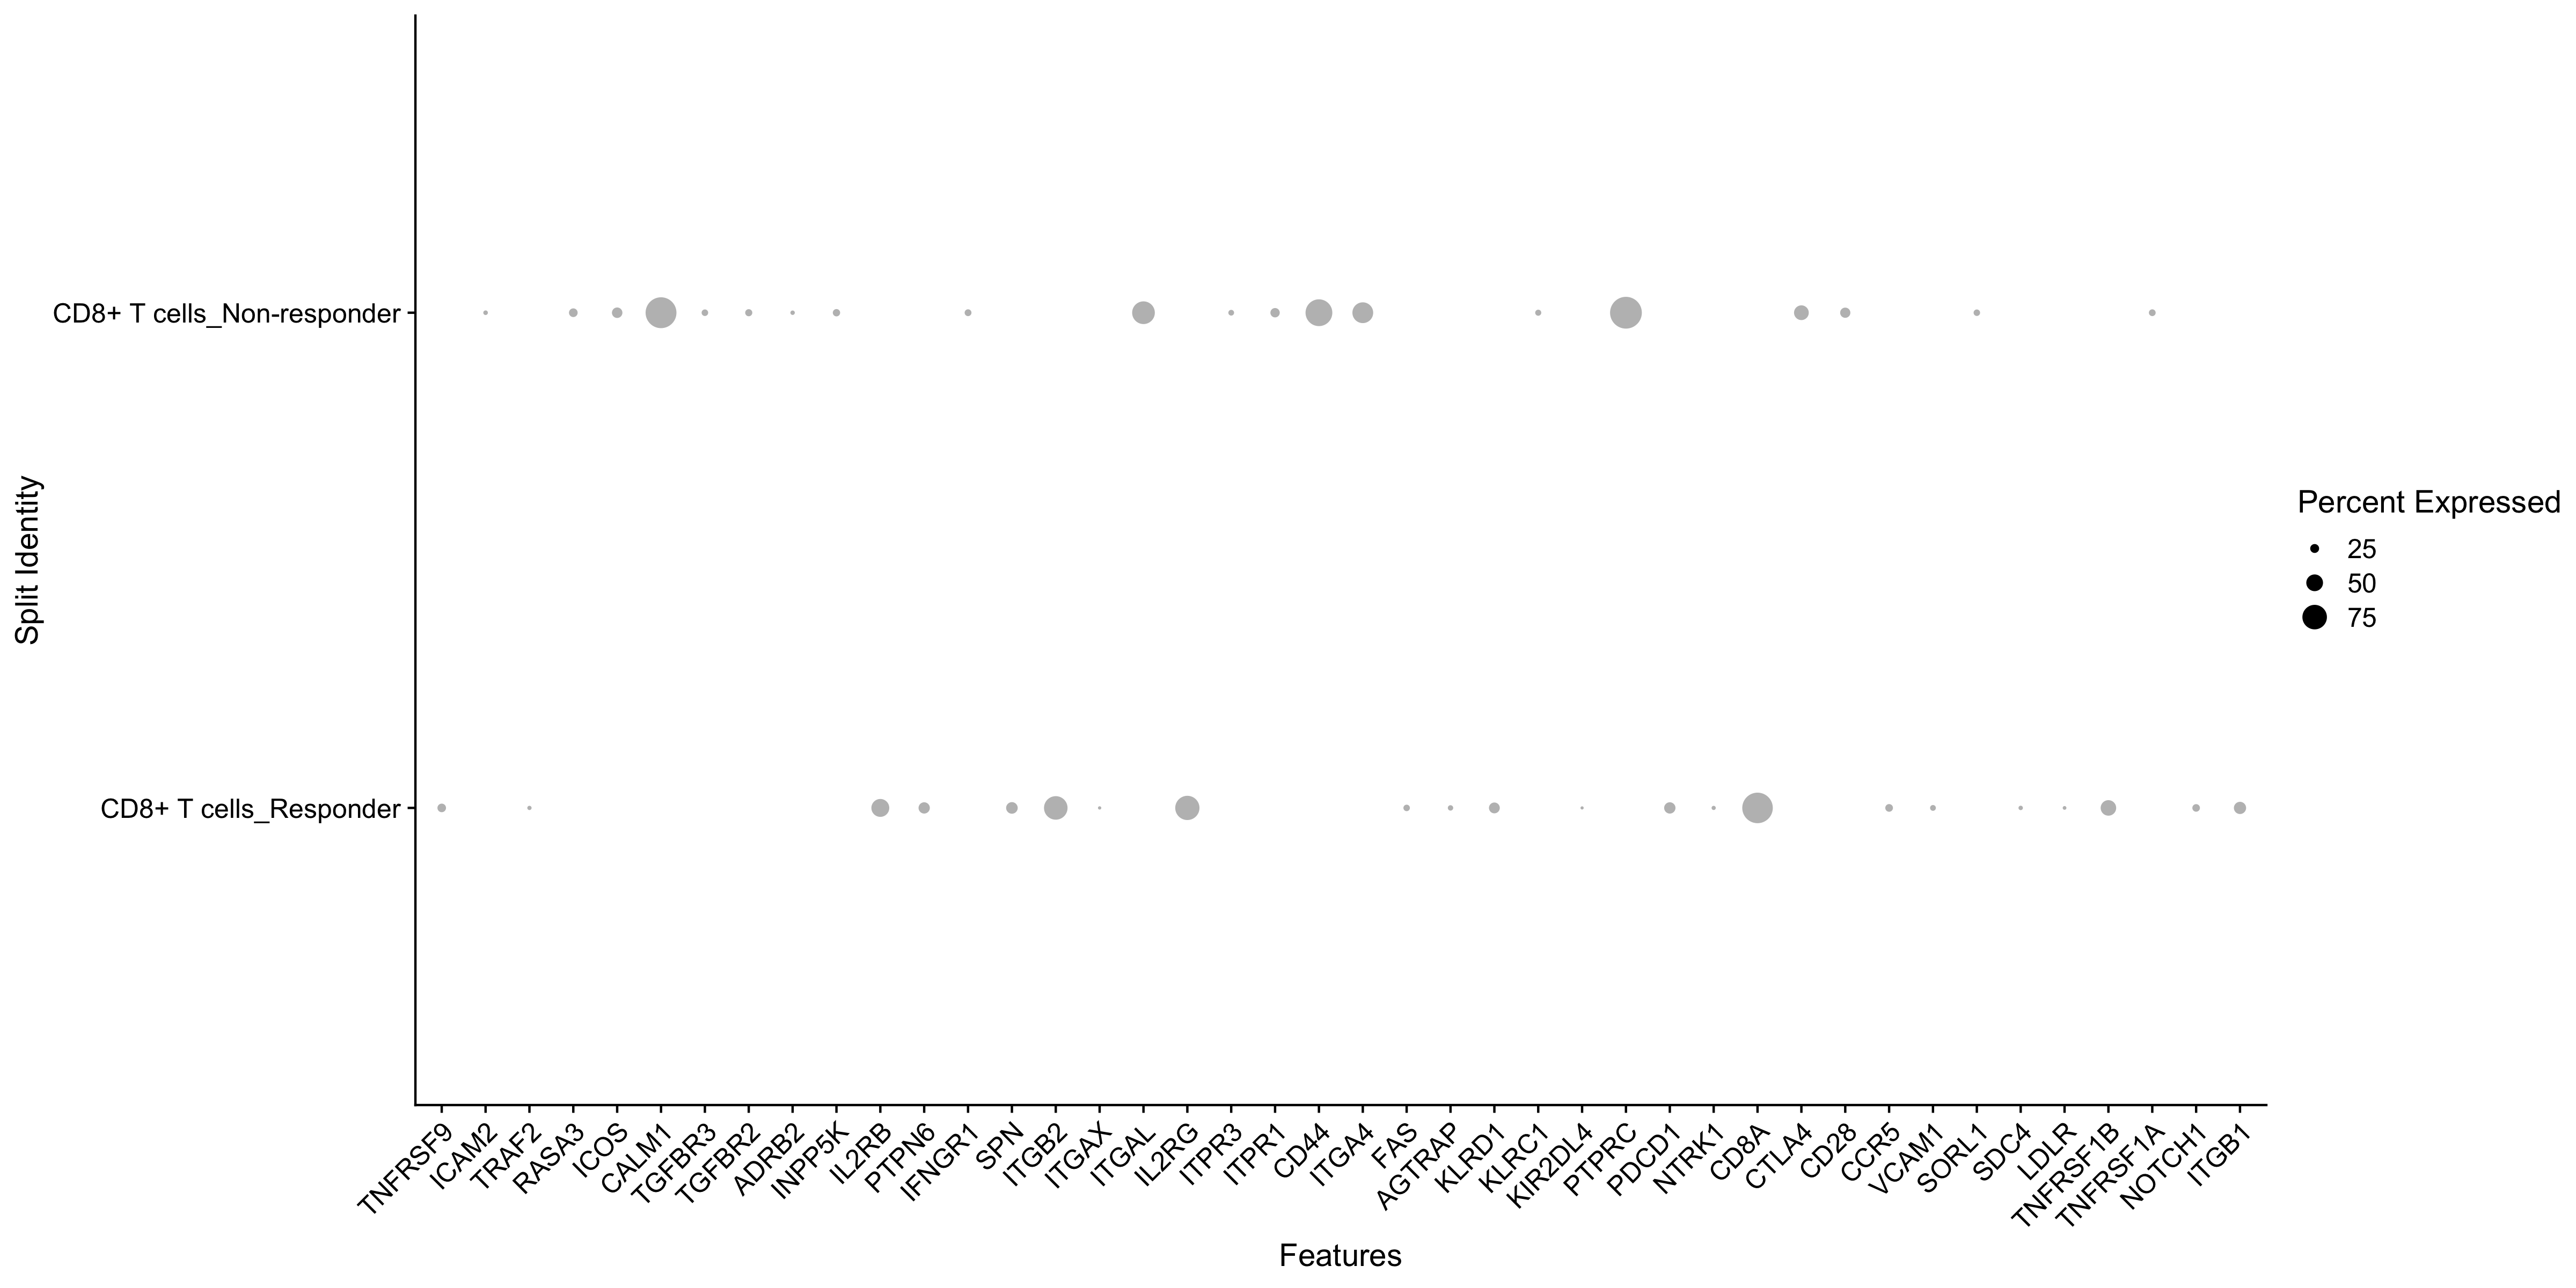

In [132]:
options(repr.plot.width=16, 
        repr.plot.height=8, 
        repr.plot.res=300)
DotPlot(seuratObj %>% 
        subset(idents = "CD8+ T cells"), 
        features = nichenet_output$top_receptors %>% rev(), 
        split.by = "response") + 
    RotatedAxis()